<a href="https://colab.research.google.com/github/anjot2807/medicine_sales_forecast/blob/main/medicine_sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset was created by consolidating information from an original dataset comprising 600,000 transactional records spanning six years (2014-2019). These records detail the date and time of sale, brand names of pharmaceutical drugs, and the quantities sold. This data was extracted from the Point-of-Sale system of individual pharmacies.

 A specific subset of drugs (57 in total) from the dataset has been categorized according to the Anatomical Therapeutic Chemical (ATC)


*   M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
*   M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives
*  N02BE/B - Other analgesics and antipyretics, Pyrazolones and Anilides
*  N05B - Psycholeptics drugs, Anxiolytic drugs
*  N05C - Psycholeptics drugs, Hypnotics and sedatives drugs
*  R03 - Drugs for obstructive airway diseases
*  R06 - Antihistamines for systemic use

In [ ]:
pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 15.9 MB/s eta 0:00:00


In [ ]:
pip install statsmodels

In [ ]:
#Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels

import datetime as dt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
register_matplotlib_converters()
from time import time

import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.base import ForecastingHorizon

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df_monthly = pd.read_csv('/content/salesmonthly.csv')
df_daily = pd.read_csv('/content/salesdaily.csv')
df_hourly= pd.read_csv('/content/saleshourly.csv')

In [ ]:
 #Print the number of rows and columns of a DataFrame
def print_shape(df, name):
    print(f"{name} DataFrame:")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print()

In [ ]:
# Print the shape of each DataFrame
print_shape(df_monthly, "Monthly Sales")
print_shape(df_daily, "Daily Sales")
print_shape(df_hourly, "Hourly Sales")

Monthly Sales DataFrame:
Number of rows: 70
Number of columns: 9

Daily Sales DataFrame:
Number of rows: 2106
Number of columns: 13

Hourly Sales DataFrame:
Number of rows: 50532
Number of columns: 13



In [ ]:
df_monthly.describe()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,149.992000,116.514286,115.020843,892.542071,262.118571,17.842857,167.675000,86.662571
std,31.485325,27.889336,31.245899,338.843908,85.060930,8.481242,81.767979,45.859336
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,137.490000,103.518250,94.375000,648.187500,223.750000,12.000000,112.000000,49.875000
50%,154.635000,114.840000,117.225000,865.824500,250.300000,18.000000,160.000000,74.100000
75%,169.000000,128.359750,133.837500,1061.580000,293.650000,23.000000,218.250000,119.807500
max,211.130000,222.351000,191.600000,1856.815000,492.000000,50.000000,386.000000,213.040000


In [ ]:
df_monthly.isnull().sum()

datum    0
M01AB    0
M01AE    0
N02BA    0
N02BE    0
N05B     0
N05C     0
R03      0
R06      0
dtype: int64

In [ ]:
df_monthly.sample(3)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
7,2014-08-31,134.79,99.780,123.8,583.850,420.0,29.0,37.00,70.8
64,2019-05-31,168.04,97.258,104.1,703.562,265.8,26.0,322.00,135.4
12,2015-01-31,135.91,130.349,141.0,1044.240,463.0,24.0,177.25,42.0


In [ ]:
#converting datatype of dates from object to Datetime
df_monthly['datum'] = pd.to_datetime(df_monthly['datum'], format= '%Y-%m-%d')


In [ ]:
df_monthly.sample(5)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
55,2018-08-31,140.00,114.719,88.25,733.838,253.0,20.0,159.0,103.1
68,2019-09-30,161.07,111.437,93.50,984.480,227.8,16.0,161.0,109.1
60,2019-01-31,179.70,222.351,99.70,1660.612,295.2,23.0,386.0,41.3
42,2017-07-31,159.67,116.206,75.20,479.350,219.0,15.0,115.0,81.1
45,2017-10-31,137.64,88.737,100.40,1184.350,226.0,15.0,247.0,51.0


In [ ]:
df_monthly.tail(5)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
65,2019-06-30,151.54,101.627,103.20,610.00,193.0,25.0,142.0,156.04
66,2019-07-31,181.00,103.541,92.80,649.80,250.6,20.0,115.0,105.20
67,2019-08-31,181.91,88.269,84.20,518.10,237.0,26.0,145.0,97.30
68,2019-09-30,161.07,111.437,93.50,984.48,227.8,16.0,161.0,109.10
69,2019-10-31,44.37,37.300,20.65,295.15,86.0,7.0,37.0,11.13


In [ ]:
df_monthly.columns

Index(['datum', 'M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03',
       'R06'],
      dtype='object')

In [ ]:
# Data for plotting
years = df_monthly['datum'].dt.year.unique()
categories = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']
data_monthly = df_monthly.groupby(df_monthly['datum'].dt.year)[categories].sum()


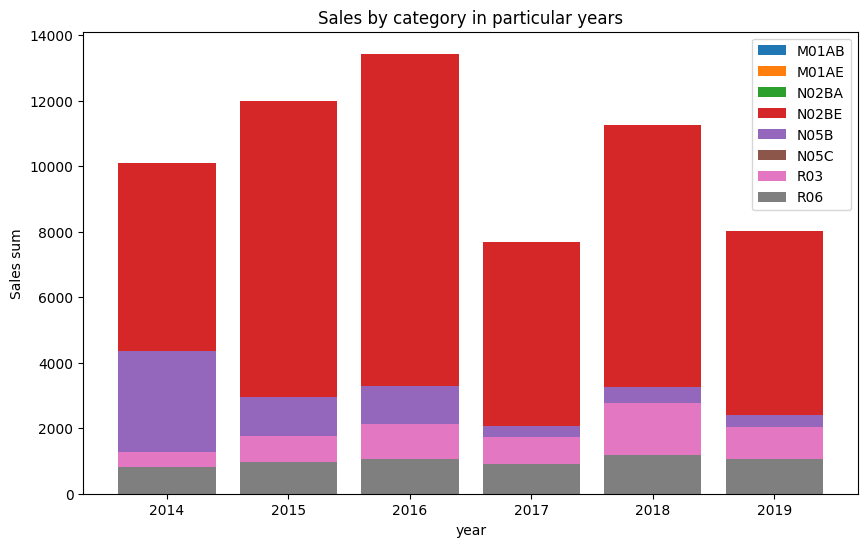

In [ ]:
# Plotting the chart
fig, ax = plt.subplots(figsize=(10, 6))

# Iteration on each cathegory
for category in categories:
    ax.bar(data_monthly.index, data_monthly[category], label=category)

# Chart configuration
ax.set_title('Sales by category in particular years')
ax.set_xlabel('year')
ax.set_ylabel('Sales sum')
ax.legend()
plt.xticks(years)  # setting the label on the x-axis as years
plt.show()

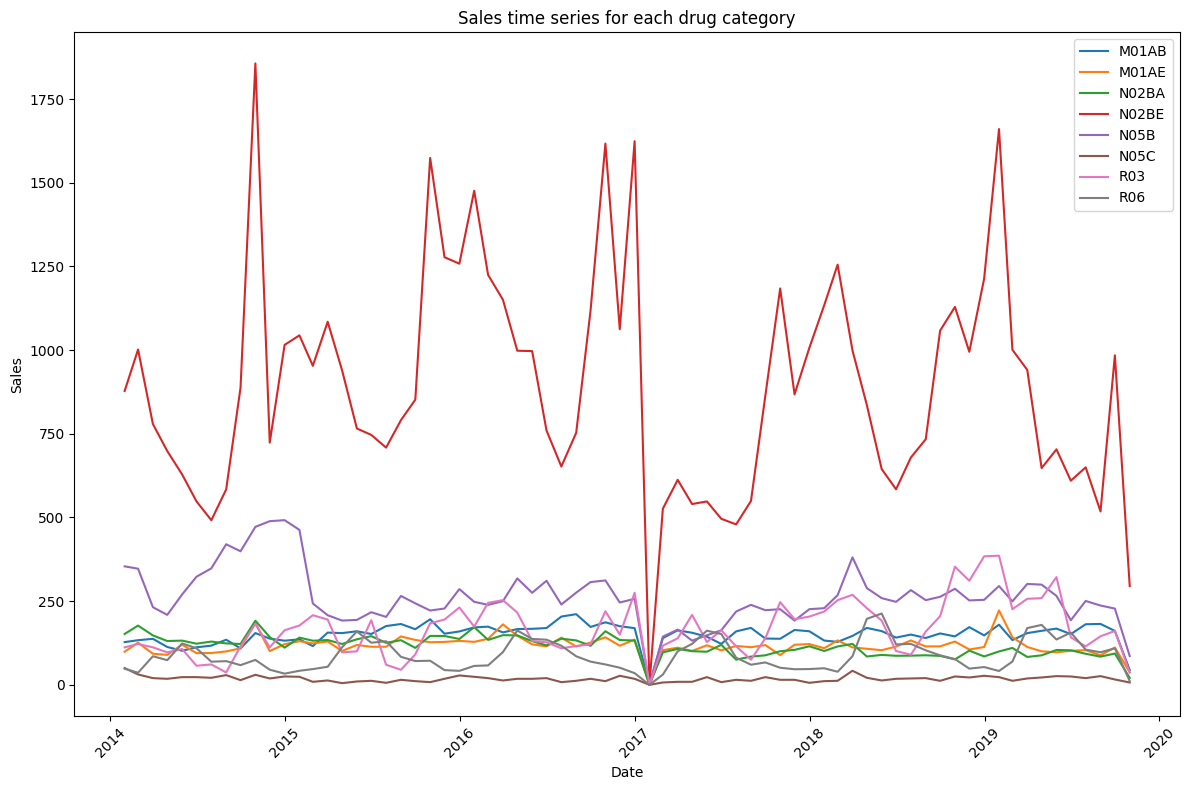

In [ ]:
# Creating a chart
fig, ax = plt.subplots(figsize=(12, 8))

for category in categories:
    ax.plot(df_monthly['datum'], df_monthly[category], label=category)

# Chart configuration
ax.set_title('Sales time series for each drug category')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.xticks(rotation=45)  # Rotate labels on the X axis for better readability
plt.tight_layout()
plt.show()

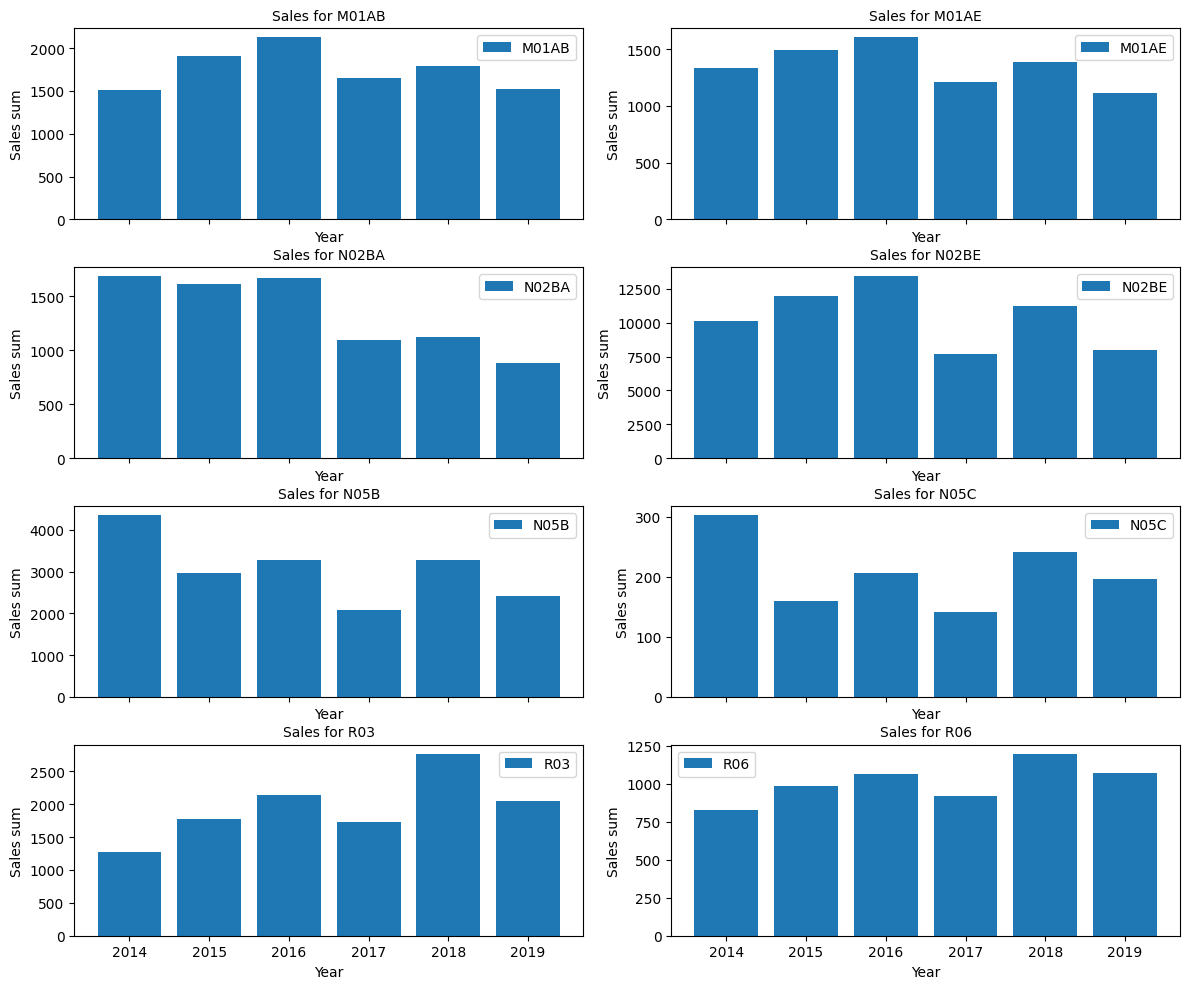

In [ ]:
# Create subplots
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 10), sharex=True)

# Flatten the axes array for easier iteration
axs = axs.flatten()
# Plot bar charts in subplots
for i, category in enumerate(categories):
    axs[i].bar(data_monthly.index, data_monthly[category], label=category)
    axs[i].set_title(f'Sales for {category}', fontsize=10)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Sales sum')
    axs[i].legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.25)

plt.show()

In [ ]:
# Grouping monthly data into years and summing clothing sales
data_yearly = df_monthly.groupby(df_monthly['datum'].dt.year)[categories].sum()

# Finding the category with the highest sales
total_sales = data_yearly.sum()
top_category = total_sales.idxmax()
top_sales = total_sales.max()
print(data_yearly)

print(f"The category with the highest sales is: {top_category} with total sales: {top_sales}")


         M01AB     M01AE     N02BA      N02BE    N05B   N05C      R03      R06
datum                                                                         
2014   1510.77  1333.594  1683.279  10094.555  4355.0  303.0  1277.00   828.30
2015   1905.62  1496.603  1608.630  11997.350  2965.0  159.0  1776.25   983.03
2016   2125.06  1604.441  1664.800  13435.830  3278.5  207.0  2137.00  1065.07
2017   1653.79  1214.485  1091.150   7674.919  2078.0  142.0  1732.00   919.61
2018   1786.93  1389.656  1123.800  11263.675  3266.2  242.0  2765.00  1196.80
2019   1517.27  1117.221   879.800   8011.616  2405.6  196.0  2050.00  1073.57
The category with the highest sales is: N02BE with total sales: 62477.94500000001


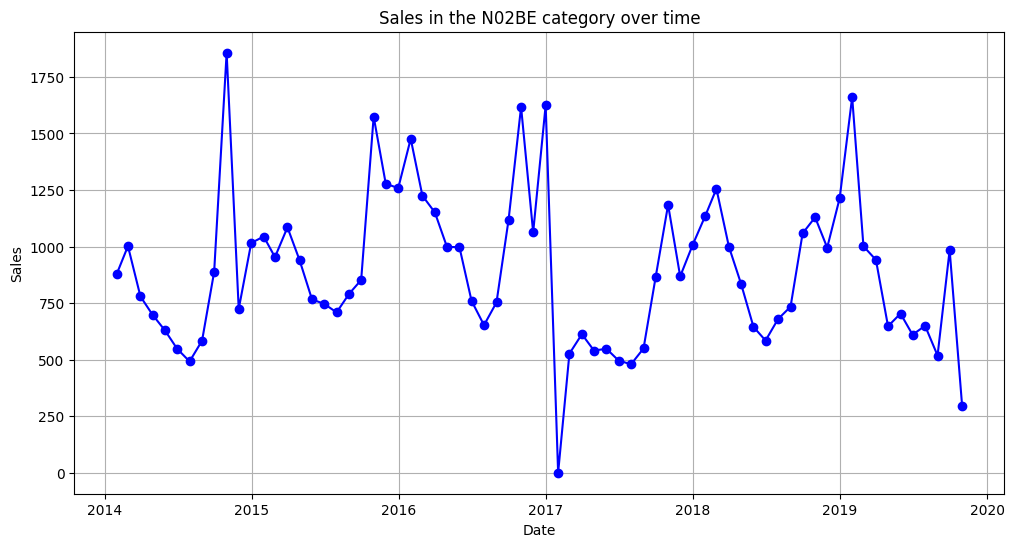

In [ ]:
# Select data for category N02BE
df_n02be = df_monthly[['datum', 'N02BE']]

# Drawing a chart
plt.figure(figsize=(12, 6))
plt.plot(df_n02be['datum'], df_n02be['N02BE'], marker='o', linestyle='-', color='b')
plt.title('Sales in the N02BE category over time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

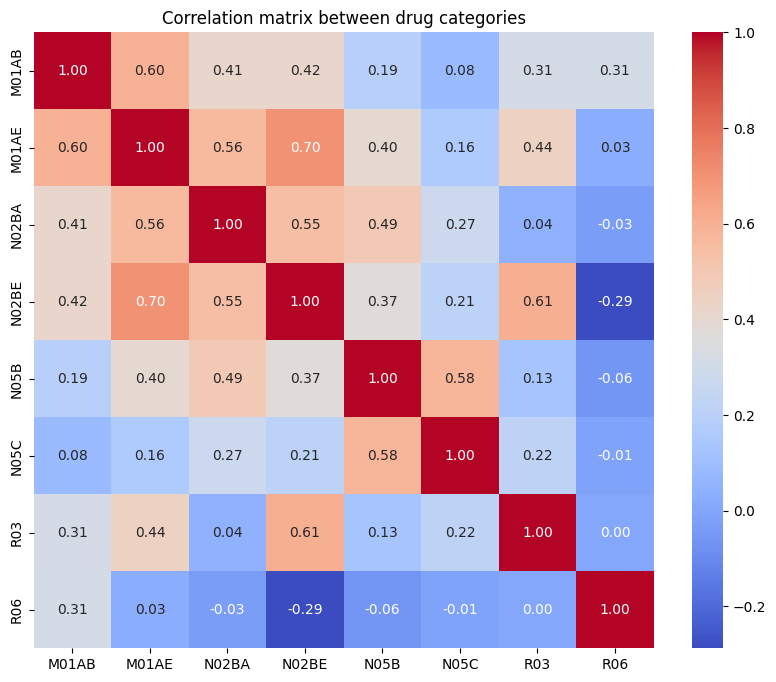

In [ ]:
# Calculation of the correlation matrix
correlation_matrix = df_monthly[categories].corr()

# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix between drug categories')
plt.show()

In [ ]:
# Compute the correlation matrix
correlation_matrix = df_monthly[categories].corr()

# Define the threshold for correlations
threshold = 0.5

# Extract significant correlations
significant_correlations = correlation_matrix[(correlation_matrix > threshold) | (correlation_matrix < -threshold)]

# Remove diagonal values (correlations of categories with themselves)
np.fill_diagonal(significant_correlations.values, np.nan)

# Display significant correlations
print("Significant correlations:")
print(significant_correlations.dropna(axis=1, how='all').dropna(axis=0, how='all'))

Significant correlations:
          M01AB     M01AE     N02BA     N02BE     N05B     N05C       R03
M01AB       NaN  0.597433       NaN       NaN      NaN      NaN       NaN
M01AE  0.597433       NaN  0.557838  0.700727      NaN      NaN       NaN
N02BA       NaN  0.557838       NaN  0.546049      NaN      NaN       NaN
N02BE       NaN  0.700727  0.546049       NaN      NaN      NaN  0.605476
N05B        NaN       NaN       NaN       NaN      NaN  0.58057       NaN
N05C        NaN       NaN       NaN       NaN  0.58057      NaN       NaN
R03         NaN       NaN       NaN  0.605476      NaN      NaN       NaN


In [ ]:
# Replace NaN values with ''
significant_correlations.fillna('', inplace=True)

# Display significant correlations without diagonal values
print("Significant correlations:")
print(significant_correlations.to_string(index=True, na_rep=''))

Significant correlations:
          M01AB     M01AE     N02BA     N02BE     N05B     N05C       R03 R06
M01AB            0.597433                                                    
M01AE  0.597433            0.557838  0.700727                                
N02BA            0.557838            0.546049                                
N02BE            0.700727  0.546049                              0.605476    
N05B                                                    0.58057              
N05C                                           0.58057                       
R03                                  0.605476                                
R06                                                                          


**1. Prophet model**

In [ ]:
from prophet import Prophet

In [ ]:
df_monthly = pd.read_csv('salesmonthly.csv', parse_dates=['datum'])

# Extract data for the N02BE category
df_n02be = df_monthly[['datum', 'N02BE']]
df_n02be.rename(columns={'datum': 'ds', 'N02BE': 'y'}, inplace=True)

# Split data into train and test sets
train = df_n02be.iloc[:-12]
test = df_n02be.iloc[-12:]
print(f'Training set size: {len(train)}')
print(f'Test set size: {len(test)}')

Training set size: 58
Test set size: 12


<ipython-input-24-523c056457da>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n02be.rename(columns={'datum': 'ds', 'N02BE': 'y'}, inplace=True)


In [ ]:
# Fit the model to the entire data
model = Prophet()
model.fit(train)

# Create a DataFrame of future dates for the forecast
future = model.make_future_dataframe(periods=12, freq='M')

# Make a forecast
forecast = model.predict(future)

# Extract the forecasted values for the last 12 months
forecast_test = forecast.iloc[-12:][['ds', 'yhat']]
forecast_test.set_index('ds', inplace=True)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0zj8avne/s22gddvg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0zj8avne/e1rehxea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98211', 'data', 'file=/tmp/tmp0zj8avne/s22gddvg.json', 'init=/tmp/tmp0zj8avne/e1rehxea.json', 'output', 'file=/tmp/tmp0zj8avne/prophet_modeldgpje1ge/prophet_model-20240719110152.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:01:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:01:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate forecast error metrics
mae_prophet = mean_absolute_error(test['y'], forecast_test)
mse_prophet = mean_squared_error(test['y'], forecast_test)
mape_prophet = mean_absolute_percentage_error(test['y'], forecast_test['yhat']) * 100


print(f'Mean Absolute Error (MAE): {mae_prophet}')
print(f'Mean Squared Error (MSE): {mse_prophet}')
print(f'MAPE: {mape_prophet:.2f}%')


Mean Absolute Error (MAE): 237.26538985170396
Mean Squared Error (MSE): 147962.50326362866
MAPE: 45.67%


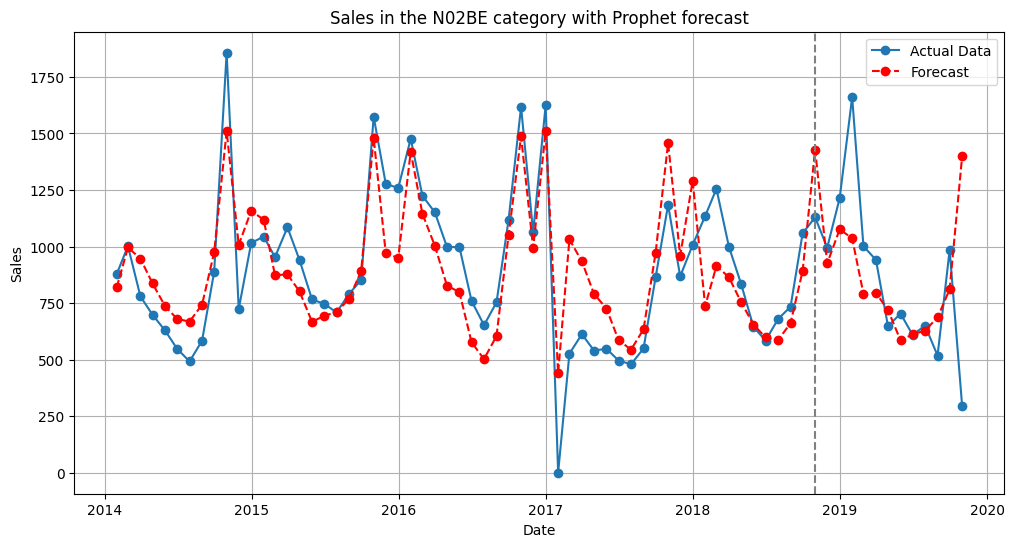

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_n02be['ds'], df_n02be['y'], label='Actual Data', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', marker='o', linestyle='--', color='r')
plt.axvline(x=df_n02be['ds'].iloc[-13], color='gray', linestyle='--')  # Indicate the start of the last 12 months
plt.title('Sales in the N02BE category with Prophet forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

2. **Sarima model**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


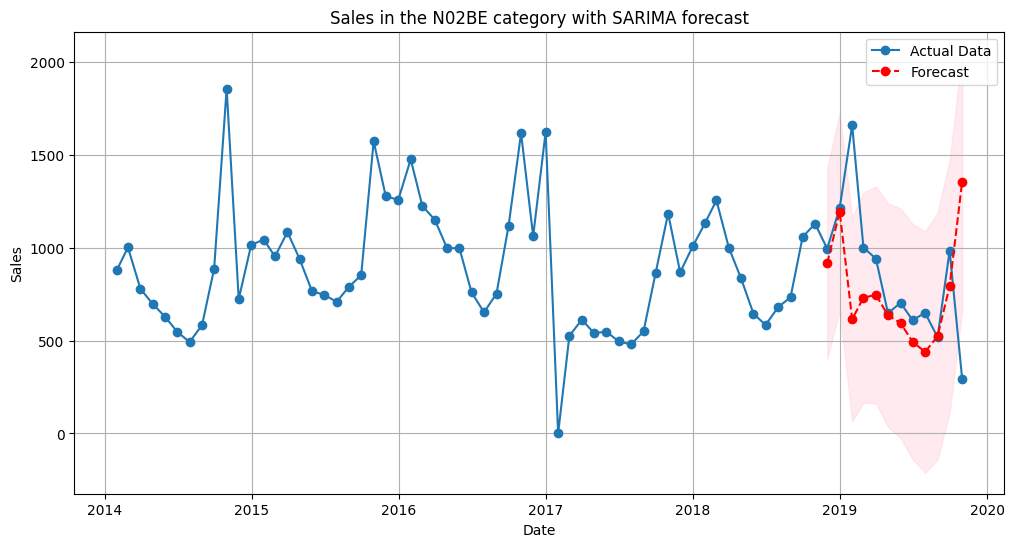

In [ ]:
# Extract data for the N02BE category
df_n02be = df_monthly[['datum', 'N02BE']]
df_n02be.set_index('datum', inplace=True)

# Split data into train and test sets
train = df_n02be.iloc[:-12]
test = df_n02be.iloc[-12:]

# Fit SARIMA model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Make predictions
forecast = results.get_forecast(steps=12)
forecast_index = test.index
forecast_values = forecast.predicted_mean

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_n02be.index, df_n02be['N02BE'], label='Actual Data', marker='o')
plt.plot(forecast_index, forecast_values, label='Forecast', marker='o', linestyle='--', color='r')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('Sales in the N02BE category with SARIMA forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate forecast error metrics
mae_sarima = mean_absolute_error(test, forecast_values)
mse_sarima = mean_squared_error(test, forecast_values)

# Obliczenie MAPE z uniknięciem dzielenia przez zero
epsilon = 1e-10  # Mała wartość do dodania w celu uniknięcia dzielenia przez zero
mape_sarima = np.mean(np.abs((test - forecast_values) / (test + epsilon))) * 100

print(f'Mean Absolute Error (MAE): {mae_sarima}')
print(f'Mean Squared Error (MSE): {mse_sarima}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_sarima}%')

Mean Absolute Error (MAE): 276.08391042388024
Mean Squared Error (MSE): 203501.19826909015
Mean Absolute Percentage Error (MAPE): nan%


3. **Holt winters model**

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
# Check the size of the dataset
dataset_size = len(df_n02be)
print(f'Total number of observations in the dataset: {dataset_size}')

Total number of observations in the dataset: 70


In [ ]:
# Extract data for the N02BE category
df_n02be = df_monthly[['datum', 'N02BE']]
df_n02be.set_index('datum', inplace=True)

train_df = df_n02be.iloc[:-12]
test_df = df_n02be.iloc[-12:]
print(f'Training set size: {len(train_df)}')
print(f'Test set size: {len(test_df)}')

# Fit Holt-Winters model
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()


Training set size: 58
Test set size: 12


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [ ]:
# Make predictions
forecast = model_fit.forecast(steps=12)

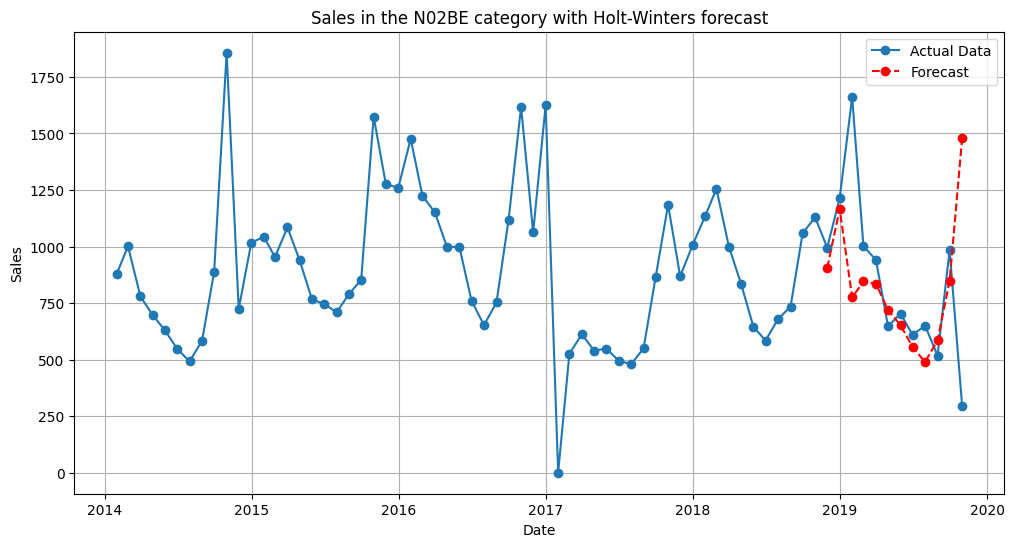

In [ ]:
 # Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_n02be.index, df_n02be['N02BE'], label='Actual Data', marker='o')
plt.plot(forecast.index, forecast, label='Forecast', marker='o', linestyle='--', color='r')
plt.title('Sales in the N02BE category with Holt-Winters forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Calculate forecast error metrics
mae_hw = mean_absolute_error(test, forecast)
mse_hw = mean_squared_error(test, forecast)
mape_hw = mean_absolute_percentage_error(test, forecast) * 100

print(f'Mean Absolute Error (MAE): {mae_hw}')
print(f'Mean Squared Error (MSE): {mse_hw}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_hw:.2f}%')

Mean Absolute Error (MAE): 250.52702674814233
Mean Squared Error (MSE): 190819.1138509848
Mean Absolute Percentage Error (MAPE): 47.70%


In [ ]:
# Create a summary table
summary_table = pd.DataFrame({
    'Model': ['SARIMA', 'Prophet', 'Holt-Winters'],
    'MAE': [mae_sarima, mae_prophet, mae_hw],
    'MSE': [mse_sarima, mse_prophet, mse_hw]
})

print(summary_table)

          Model         MAE            MSE
0        SARIMA  276.083910  203501.198269
1       Prophet  237.265390  147962.503264
2  Holt-Winters  250.527027  190819.113851


The Prophet model has the lowest Mean Absolute Error (MAE) of 168.355172 and the lowest Mean Squared Error (MSE) of 74839.673102. This indicates that the Prophet model performs better in terms of forecasting accuracy compared to the SARIMA and Holt-Winters models.

Daily sales - analysis

In [ ]:
df_daily.tail(5)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
2101,10/4/2019,7.34,5.683,2.25,22.45,13.0,0.0,1.0,1.00,2019,10,276,Friday
2102,10/5/2019,3.84,5.010,6.00,25.40,7.0,0.0,0.0,0.33,2019,10,276,Saturday
2103,10/6/2019,4.00,11.690,2.00,34.60,6.0,0.0,5.0,4.20,2019,10,276,Sunday
2104,10/7/2019,7.34,4.507,3.00,50.80,6.0,0.0,10.0,1.00,2019,10,276,Monday
2105,10/8/2019,0.33,1.730,0.50,44.30,20.0,2.0,2.0,0.00,2019,10,190,Tuesday


In [ ]:
df_daily.isnull().sum()

datum           0
M01AB           0
M01AE           0
N02BA           0
N02BE           0
N05B            0
N05C            0
R03             0
R06             0
Year            0
Month           0
Hour            0
Weekday Name    0
dtype: int64

In [ ]:
#converting datatype of dates from object to Datetime
df_daily['datum'] = pd.to_datetime(df_daily['datum'], format='%m/%d/%Y')

In [ ]:
df_daily.columns

Index(['datum', 'M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03',
       'R06', 'Year', 'Month', 'Hour', 'Weekday Name'],
      dtype='object')

In [ ]:
df_daily.head(5)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,2014-01-02,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,2014-01-03,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,2014-01-04,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,2014-01-05,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,2014-01-06,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


In [ ]:
# Grouping data by day of the month and calculating average sales for each group
daily_sales = df_daily.groupby(df_daily['datum'].dt.day)[['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']].mean()

# Finding the highest sales day for each drug group
max_sales_days = daily_sales.idxmax()


In [ ]:
# plotting table
summary_table = pd.DataFrame({
    'Group of drugs': max_sales_days.index,
    'Day of the month with the biggest sale': max_sales_days.values
})


print(summary_table)

  Group of drugs  Day of the month with the biggest sale
0          M01AB                                      11
1          M01AE                                      10
2          N02BA                                      10
3          N02BE                                      31
4           N05B                                      11
5           N05C                                       9
6            R03                                      28
7            R06                                      11


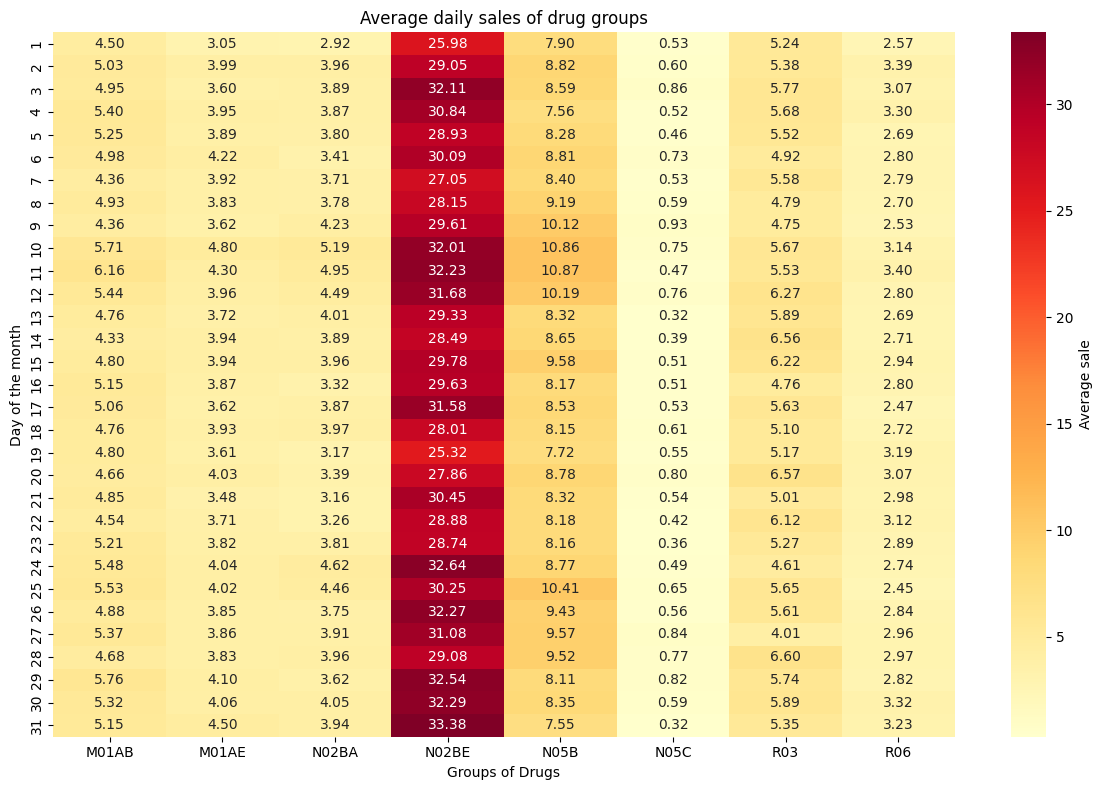

In [ ]:
# plotting table
plt.figure(figsize=(12, 8))
sns.heatmap(daily_sales, cmap='YlOrRd', annot=True, fmt='.2f', cbar_kws={'label': 'Average sale'})
plt.title('Average daily sales of drug groups')
plt.xlabel('Groups of Drugs')
plt.ylabel('Day of the month')
plt.tight_layout()
plt.show()

Hourly sale

In [ ]:
df_hourly.tail(5)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
50527,10/8/2019 15:00,0.00,0.40,0.0,11.3,1.0,0.0,0.0,0.0,2019,10,15,Tuesday
50528,10/8/2019 16:00,0.33,0.00,0.0,1.0,2.0,0.0,0.0,0.0,2019,10,16,Tuesday
50529,10/8/2019 17:00,0.00,0.00,0.0,1.0,2.0,0.0,1.0,0.0,2019,10,17,Tuesday
50530,10/8/2019 18:00,0.00,0.00,0.0,9.0,0.0,0.0,0.0,0.0,2019,10,18,Tuesday
50531,10/8/2019 19:00,0.00,0.33,0.0,8.0,1.0,0.0,1.0,0.0,2019,10,19,Tuesday


In [ ]:
df_hourly['datum'] = pd.to_datetime(df_hourly['datum'], format='%m/%d/%Y %H:%M')

In [ ]:
df_hourly.head(5)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,2014-01-02 08:00:00,0.0,0.67,0.4,2.0,0.0,0.0,0.0,1.0,2014,1,8,Thursday
1,2014-01-02 09:00:00,0.0,0.00,1.0,0.0,2.0,0.0,0.0,0.0,2014,1,9,Thursday
2,2014-01-02 10:00:00,0.0,0.00,0.0,3.0,2.0,0.0,0.0,0.0,2014,1,10,Thursday
3,2014-01-02 11:00:00,0.0,0.00,0.0,2.0,1.0,0.0,0.0,0.0,2014,1,11,Thursday
4,2014-01-02 12:00:00,0.0,2.00,0.0,5.0,2.0,0.0,0.0,0.0,2014,1,12,Thursday


In [ ]:
# Summing the sales of all drug groups for each row
df_hourly['total_sales'] = df_hourly[['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']].sum(axis=1)

# Grouping by hour and calculating the total sales
hourly_sales = df_hourly.groupby('Hour')['total_sales'].sum().reset_index()

# Finding the hour with the highest sales
peak_hour = hourly_sales.loc[hourly_sales['total_sales'].idxmax()]


In [ ]:
# Creating a summary table
print("Summary table of total drug sales throughout the day:")
print(hourly_sales)
print(f"\nHour with the highest sales: {peak_hour['Hour']}:00")
print(f"Total sales at this hour: {peak_hour['total_sales']:.2f}")


Summary table of total drug sales throughout the day:
    Hour   total_sales
0      0      0.000000
1      1      0.000000
2      2      0.000000
3      3      0.000000
4      4      0.000000
5      5      0.000000
6      6      0.000000
7      7    572.567500
8      8   6040.749167
9      9   8094.519667
10    10   9591.414042
11    11  10733.956083
12    12  10546.213542
13    13   9573.369188
14    14   8780.673375
15    15   8186.917917
16    16   7851.946875
17    17   8254.304333
18    18  10071.576917
19    19  11321.757917
20    20  11211.060958
21    21   6603.472458
22    22    160.420417
23    23      0.583333

Hour with the highest sales: 19.0:00
Total sales at this hour: 11321.76


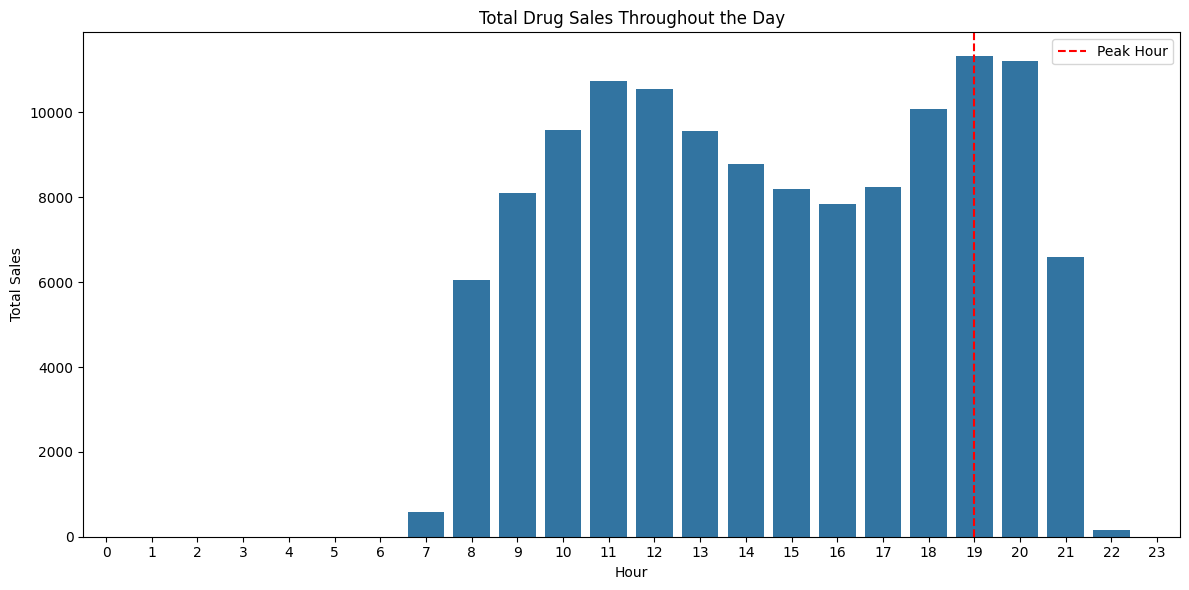

In [ ]:
# Creating the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Hour', y='total_sales', data=hourly_sales)
plt.title('Total Drug Sales Throughout the Day')
plt.xlabel('Hour')
plt.ylabel('Total Sales')
plt.xticks(range(0, 24))
plt.axvline(x=peak_hour['Hour'], color='r', linestyle='--', label='Peak Hour')
plt.legend()
plt.tight_layout()
plt.show()

The data clearly identifies the hours with the highest sales volume. Management should ensure that the maximum number of staff members are available during these peak times to handle the increased customer flow and maintain high-quality service.

 This forecasting model in pharmaceutical sales not only enhances logistics and storage efficiency but also significantly reduces operational costs. By understanding time-sensitive demand patterns for different drug groups, pharmacies can optimize their inventory strategies, ultimately leading to improved service delivery and patient satisfaction.